In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap


df = pd.read_csv("../data/processed/df_clean.csv")
X = df.drop(columns=['Churn','customerID'])
y = df['Churn']

# Split train/val/test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
lr = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_proba_lr = lr.predict_proba(X_val)[:,1]
auc_lr=roc_auc_score(y_val, y_proba_lr)

print("F1-score:", f1_score(y_val, y_pred_lr))
print("AUC:", auc_lr)


F1-score: 0.6416666666666667
AUC: 0.8588404566956845


In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:,1]
auc_rf=roc_auc_score(y_val, y_proba_rf)

print("RF F1-score:", f1_score(y_val, y_pred_rf))
print("RF AUC:", auc_rf)


RF F1-score: 0.6287787182587666
RF AUC: 0.8593968345979071


In [21]:
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb
import numpy as np

# Compute class imbalance ratio (negatives / positives)
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / n_pos
print(scale_pos_weight)

# Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Define model parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight  # handle class imbalance
}

# Train model with early stopping
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_eval],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(20)]
)

# Predictions
y_proba_lgb = lgb_model.predict(X_val)
y_pred_lgb = (y_proba_lgb > 0.5).astype(int)

# Evaluation metrics
auc_lgb = roc_auc_score(y_val, y_proba_lgb)

print("LGB scale_pos_weight:", scale_pos_weight)
print("LGB F1-score:", f1_score(y_val, y_pred_lgb))
print("LGB AUC:", auc_lgb)


2.766042780748663
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
Training until validation scores don't improve for 50 rounds
[20]	valid_0's auc: 0.855042
[40]	valid_0's auc: 0.857658
[60]	valid_0's auc: 0.859984
[80]	valid_0's auc: 0.858155
[100]	valid_0's auc: 0.855632
Early stopping, best iteration is:
[60]	valid_0's auc: 0.859984
LGB scale_pos_weight: 2.766042780748663
LGB F1-score: 0.643956043956044
LGB AUC: 0.859984266150486


In [23]:
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# Compute scale_pos_weight to handle class imbalance
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

# Prepare DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'seed': 42,
    'scale_pos_weight': scale_pos_weight  # handle class imbalance
}

# Train model with early stopping
xgb_model = xgb.train(
    params_xgb,
    dtrain,
    num_boost_round=200,
    evals=[(dval, 'validation')],
    early_stopping_rounds=20,
    verbose_eval=20
)

# Predictions
y_proba_xgb = xgb_model.predict(dval)
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

# Evaluation metrics
auc_xgb = roc_auc_score(y_val, y_proba_xgb)

print("XGB F1-score:", f1_score(y_val, y_pred_xgb))
print("XGB AUC:", auc_xgb)


[0]	validation-auc:0.83002
[20]	validation-auc:0.85142
[40]	validation-auc:0.85501
[60]	validation-auc:0.85615
[80]	validation-auc:0.85666
[100]	validation-auc:0.85508
XGB F1-score: 0.6460176991150443
XGB AUC: 0.8550752015899471


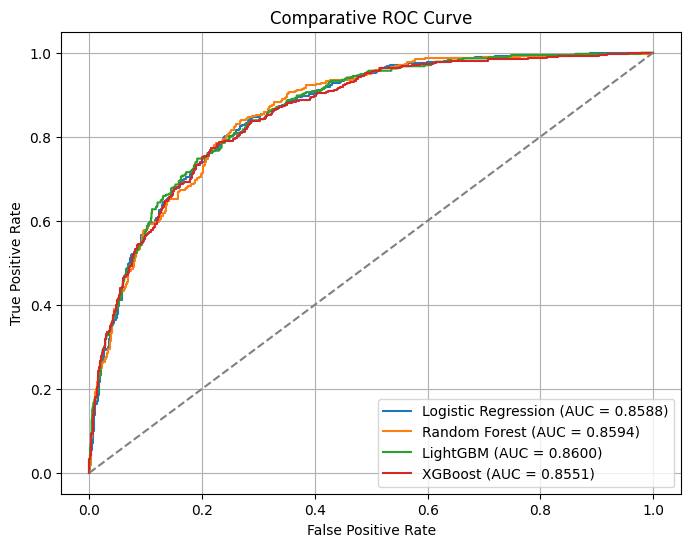

In [24]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_val, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_proba_lgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_proba_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curve')
plt.legend()
plt.grid()
plt.show()


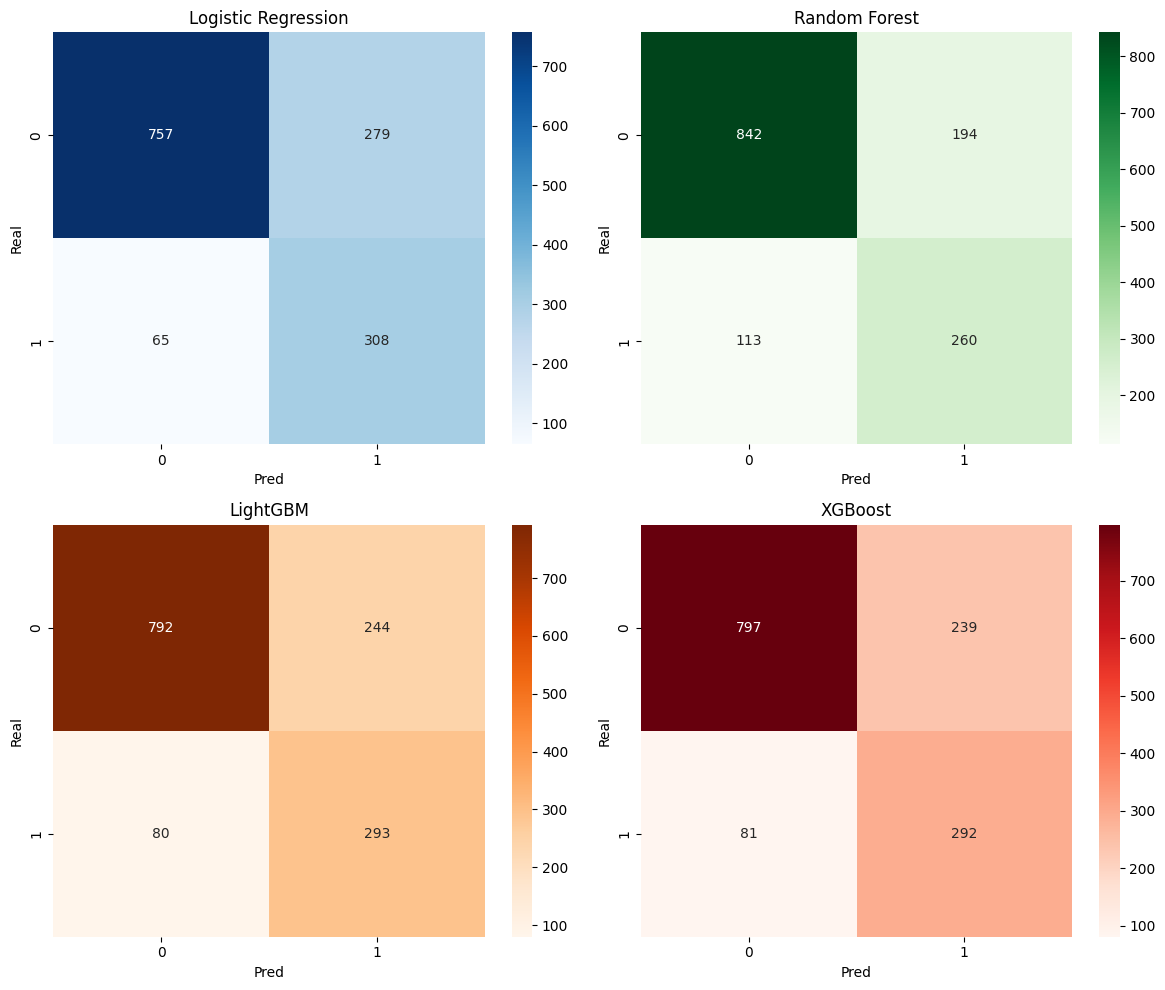

In [25]:
cm_lr = confusion_matrix(y_val, y_pred_lr)
cm_rf = confusion_matrix(y_val, y_pred_rf)
cm_lgb = confusion_matrix(y_val, y_pred_lgb)
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

fig, axes = plt.subplots(2, 2, figsize=(12,10))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Logistic Regression')
axes[0,0].set_xlabel('Pred')
axes[0,0].set_ylabel('Real')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('Random Forest')
axes[0,1].set_xlabel('Pred')
axes[0,1].set_ylabel('Real')

sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Oranges', ax=axes[1,0])
axes[1,0].set_title('LightGBM')
axes[1,0].set_xlabel('Pred')
axes[1,0].set_ylabel('Real')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', ax=axes[1,1])
axes[1,1].set_title('XGBoost')
axes[1,1].set_xlabel('Pred')
axes[1,1].set_ylabel('Real')

plt.tight_layout()
plt.show()


c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


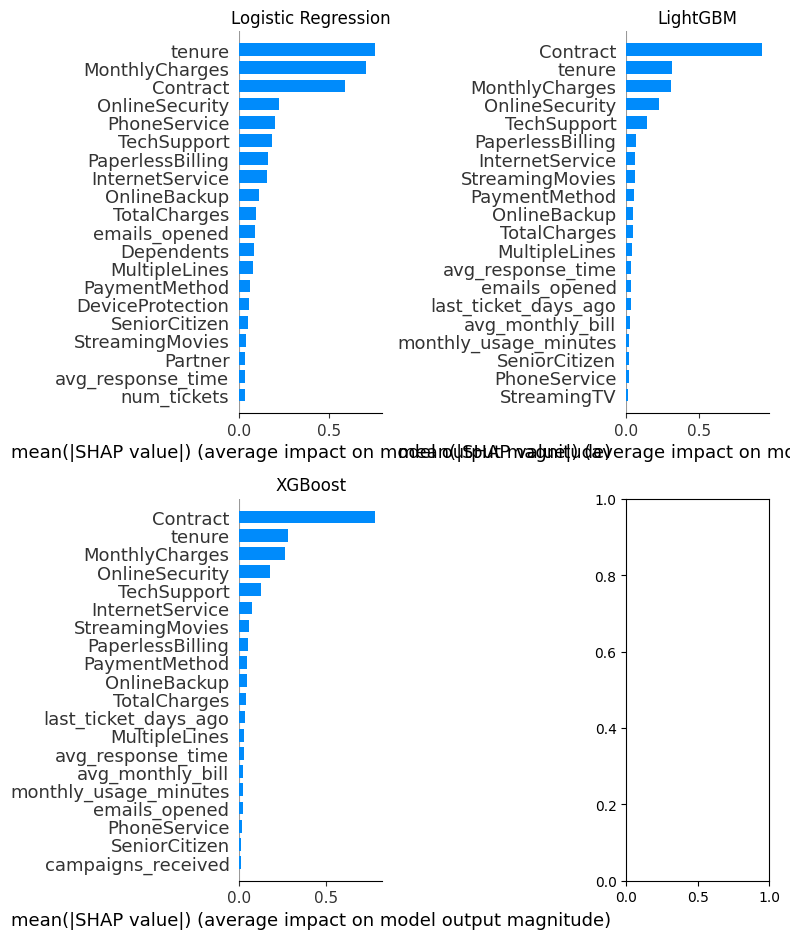

In [ ]:
explainer_lr = shap.LinearExplainer(lr, X_train, feature_perturbation="interventional")
explainer_rf = shap.TreeExplainer(rf)
explainer_lgb = shap.TreeExplainer(lgb_model)
explainer_xgb = shap.TreeExplainer(xgb_model)

shap_values_lr = explainer_lr.shap_values(X_val)
shap_values_rf = explainer_rf.shap_values(X_val)
shap_values_lgb = explainer_lgb.shap_values(X_val)
shap_values_xgb = explainer_xgb.shap_values(X_val)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Logistic Regression
plt.sca(axes[0,0])
shap.summary_plot(shap_values_lr, X_val, plot_type="bar", show=False)
plt.title("Logistic Regression")


# LightGBM
plt.sca(axes[0,1])
shap.summary_plot(shap_values_lgb, X_val, plot_type="bar", show=False)
plt.title("LightGBM")

# XGBoost
plt.sca(axes[1,0])
shap.summary_plot(shap_values_xgb, X_val, plot_type="bar", show=False)
plt.title("XGBoost")

plt.tight_layout()
plt.show()
